In [21]:
import sklearn.preprocessing

from finance_analysis import FinancialInstrument as fi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

class Stock_Dataset(fi):
    def __init__(self,windows: list,horizons: list,intercross: bool,lookover: bool,**kwargs):
        """
        This class creates multiple datasets with varying windows and varying horizons so that multiple datasets
        can be created quickly.
        :param windows: List of windows to be produced. i.e if window is 7 then number of prices in X would be 7
        :param horizons: List of horizons to be produced. i.e. if horizon is 1 then Y will have price movement for 1 day.
        :param intercross: if true: eg. if windows = [5,7] and horizon = [2,3] then dataset produced would have
        [(5,2),(5,3),(7,2),(7,3)] windows and horizon pair respectively.
        else: the window horizon pair would be [(5,2),(7,3)]
        :param lookover: if true then single day windows would have prices for that day only not for the previous day where as otherwise
        they would have prices from previous day too. It is specifically for intra-day trading where we might not want previous day's prices to
        affect the model.
        :param kwargs: keyword arguments for Financial Instrument class which are ticker, start, end and interval specifically.
        """
        super().__init__(**kwargs)
        self.windows = windows
        self.horizons = horizons
        self.lookover = lookover
        self.intercross = intercross

    def create_dataset(self):
        self.dataset = {}
        if self.intercross:
            wh_list = list(product(self.windows,self.horizons))
        else:
            wh_list = [(i,j) for i,j in zip(self.windows,self.horizons)]

        for (i,j) in wh_list:
            tmp_dataset = self.create_windows_horizons(i,j)
            self.dataset[f'data_{i}_{j}'] = tmp_dataset


    def w_h(self,data,window,horizon):
        data['position'] = np.log(data.price / data.price.shift(horizon)).apply(lambda x: 1 if x>=0 else -1)
        data.dropna(inplace=True)
        for i in range(1,window+1):
            col = f't-{i}'
            data[col] = data.log_returns.shift(i)

        data.dropna(inplace=True)
        return data.copy()

    def create_windows_horizons(self,window,horizon):
        if self.lookover:
            grp = self.data.groupby(pd.Grouper(freq='D'))
            data_f = None
            for (t,val) in grp:
                val_2 = val.copy()
                tmp_data = self.w_h(val_2,window,horizon)
                if data_f is None:
                    data_f = tmp_data
                else:
                    data_f = pd.concat([data_f,tmp_data])

        else:
            data_f = self.w_h(self.data.copy(),window,horizon)

        return data_f



In [46]:
tata_data = Stock_Dataset(windows=[10],horizons=[3],intercross=False,lookover=False,ticker='TATAMOTORS.NS',start='2018-01-01',end=pd.Timestamp.today(),interval='1D')

[*********************100%***********************]  1 of 1 completed


In [22]:
infy_data = Stock_Dataset(windows=[10],horizons=[3],intercross=False,lookover=False,ticker='INFY.NS',start='2018-01-01',end=pd.Timestamp.today(),interval='1D')

[*********************100%***********************]  1 of 1 completed


In [97]:
tata_data.create_dataset()

In [103]:
tata_data.dataset['data_10_3'].position.head()

Date
2018-01-16 00:00:00+05:30   -1
2018-01-17 00:00:00+05:30   -1
2018-01-18 00:00:00+05:30   -1
2018-01-19 00:00:00+05:30    1
2018-01-22 00:00:00+05:30    1
Name: position, dtype: int64

In [104]:
tata_data.dataset['data_10_3'].position.value_counts()

-1    642
 1    627
Name: position, dtype: int64

In [44]:
np.log(infy_data.data.price / infy_data.data.price.shift(3)).dropna().iloc[::3].apply(lambda x: x if x>=0 else 0).sum()

5.303444152856573

In [58]:
np.log(tata_data.data.price / tata_data.data.price.shift(3)).dropna().iloc[::3] #.apply(lambda x: x if x>=0 else 0).sum()

Date
2018-01-04 00:00:00+05:30    0.012875
2018-01-09 00:00:00+05:30    0.017522
2018-01-12 00:00:00+05:30   -0.001029
2018-01-17 00:00:00+05:30   -0.032908
2018-01-22 00:00:00+05:30   -0.002486
                               ...   
2023-02-14 00:00:00+05:30    0.008663
2023-02-17 00:00:00+05:30   -0.001477
2023-02-22 00:00:00+05:30   -0.024042
2023-02-27 00:00:00+05:30   -0.027144
2023-03-02 00:00:00+05:30    0.005964
Name: price, Length: 426, dtype: float64

In [89]:
resampled_first = infy_data.data.price.resample('3D').first()
resampled_last = infy_data.data.price.iloc[2:].resample('3D').first()
resampled_mid = infy_data.data.price.iloc[1:].resample('3D').first()
funct = (lambda x: x if x>=0 else 0)
log_1 = np.log(resampled_first / resampled_first.shift(1))
log_2 = np.log(resampled_mid/ resampled_mid.shift(1))
log_3 = np.log(resampled_last / resampled_last.shift(1))
# print(log.apply(funct).sum())
print(log_2.apply(funct).sum())
print(log_3.apply(funct).sum())

8.931071044530674
6.030765331238655
5.873857402438013


In [85]:
resampled_last

Date
2018-01-03 00:00:00+05:30    433.899994
2018-01-06 00:00:00+05:30    433.549988
2018-01-09 00:00:00+05:30    437.549988
2018-01-12 00:00:00+05:30    437.100006
2018-01-15 00:00:00+05:30    432.350006
                                ...    
2023-02-18 00:00:00+05:30    443.000000
2023-02-21 00:00:00+05:30    436.500000
2023-02-24 00:00:00+05:30    427.750000
2023-02-27 00:00:00+05:30    417.950012
2023-03-02 00:00:00+05:30    420.450012
Freq: 3D, Name: price, Length: 629, dtype: float64

In [72]:
print(tata_data.data.price.shift(3).iloc[::3].head())

Date
2018-01-01 00:00:00+05:30           NaN
2018-01-04 00:00:00+05:30    424.450012
2018-01-09 00:00:00+05:30    429.950012
2018-01-12 00:00:00+05:30    437.549988
2018-01-17 00:00:00+05:30    437.100006
Name: price, dtype: float64


In [90]:
tata_data.data.price.diff(1).apply(lambda x: x if x>=0 else 0).sum()

3348.3999633789062

In [92]:
tata_data.data.price[0]

424.45001220703125

In [93]:
3348/424

7.89622641509434

In [49]:
from finance_analysis import FinancialInstrument as fi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

class Stock_Dataset(fi):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.dataset = None

    def create_dataset(self,qty=3,window=None,horizon=None):
        self.window = window
        self.horizon = horizon
        self.qty=qty
        signal_dict = {}
        for i in range(len(self.data)-self.horizon):
            price_on_day = self.data.price[i]
            for j in range(1,self.horizon+1):
                if f't+{j}' not in signal_dict.keys():
                    signal_dict[f't+{j}'] = []
                f_price = self.data.price.iloc[i+j]
                turnover = self.qty*(f_price+price_on_day)
                stt = round(0.1*turnover/100)
                txn_nse = round(0.00345*turnover/100,2)
                gst = round(18/100*txn_nse,2)
                stamp = round(0.015/100*qty*self.data.price.iloc[i])
                dp = 15.94
                tax = stt+txn_nse+gst+stamp+dp
                s_pnl = f_price - price_on_day
                if s_pnl>0:
                    pnl = s_pnl-tax
                    if pnl>0:
                        signal_dict[f't+{j}'].append(1)
                    else:
                        signal_dict[f't+{j}'].append(0)
                else:
                    pnl = s_pnl + tax
                    if pnl>0:
                        signal_dict[f't+{j}'].append(0)
                    else:
                        signal_dict[f't+{j}'].append(-1)


        for i in signal_dict.keys():
            self.data[i] = signal_dict[i]+[None]*self.horizon

        for i in range(1,self.window):
            self.data[f't-{i}'] = self.data.log_returns.shift(i)

        key_ls = []
        for k in range(-self.window+1,self.horizon+1):
            if k==0:
                key = 'log_returns'
            else:
                key = f't+{k}' if k>0 else f't{k}'
            key_ls.append(key)

        self.data[key_ls].dropna(inplace=True)

        new_targets = []
        target_ls = [f't+{i}' for i in range(1,self.horizon+1)]
        target_array = self.data[target_ls].to_numpy().astype(np.int32)
        for i in target_array:
            n_zero = 0
            for j in i:
                if j!=0:
                    n_zero=1
                    new_targets.append(j)
                    break
            if n_zero==0:
                new_targets.append(0)
        self.data['final_targets'] = new_targets

        key_ls = ['price'] + key_ls + ['final_targets']
        self.dataset = self.data[key_ls].dropna().copy()
        return self.dataset


In [51]:
tata_stock = Stock_Dataset(ticker='TATAMOTORS.NS',start='2011-01-01',end=pd.Timestamp.today(),interval='1D')

[*********************100%***********************]  1 of 1 completed


In [55]:
tata_ds = tata_stock.create_dataset(qty=3,window=20,horizon=10)

/tmp/ipykernel_6804/271236298.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[key_ls].dropna(inplace=True)


In [56]:
tata_ds.final_targets.value_counts()

 0    1055
 1     971
-1     961
Name: final_targets, dtype: int64

In [34]:
target_ls = [f't+{i}' for i in range(1,8)]
target_array = tata_ds[target_ls].to_numpy().astype(np.int32)

In [35]:
new_targets = []
for i in target_array:
    n_zero = 0
    for j in i:
        if j!=0:
            n_zero=1
            new_targets.append(j)
            break
    if n_zero==0:
        new_targets.append(0)

In [18]:
target_s = pd.Series(new_targets)

In [19]:
target_s.head()

0    1
1    0
2    0
3    1
4    1
dtype: int64

In [20]:
target_s.value_counts()

 0    1517
 1     736
-1     736
dtype: int64

In [37]:
len(tata_ds)

2989

In [38]:
tata_ds.final_targets.value_counts()

 0    1517
 1     736
-1     736
Name: final_targets, dtype: int64

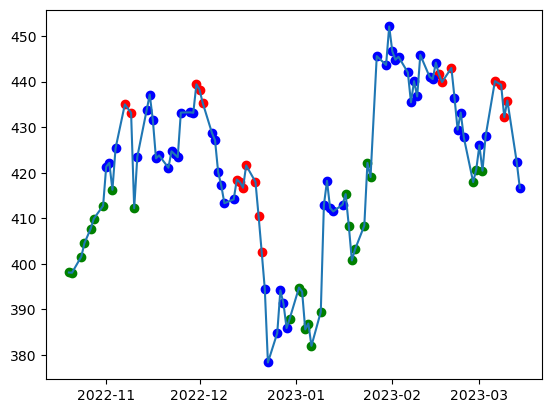

In [46]:
x=100
plt.plot(tata_ds.price[-x:])
plt.scatter(y=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==1],x=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==1].index,color='g')
plt.scatter(y=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==-1],x=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==-1].index,color='r')
plt.scatter(y=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==0],x=tata_ds.price[-x:].loc[tata_ds.final_targets[-x:]==0].index,color='b')

# Class

In [2]:
from finance_analysis import FinancialInstrument as fi
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
# import seaborn as sns

In [66]:
class Stock_Instrument(fi):
    def __init__(self,windows,horizon,lookover,**kwargs):
        '''
        This class leverages Financial Instrument class to download data from yfinance and calculates
        Technical Indicators. It windows them and the technical Indicators and returns the dataset.
        The technical indicators calculated are:
            * MACD: Moving Average Convergence and Divergence on the Close price with fast
                    period = 12, slow period = 26 and signal period = 9
            *

        '''
        super().__init__(**kwargs)
        self.windows = windows
        self.horizon =  horizon
        self.lookover = lookover
        self.windowed_dataset = None
        self.targets = None
        print("Calculating Indicators...")
        self.calculate_indicators()
        print("Preprocessing the data...")
        self.preprocessing()
        print("Windowing the dataset.")
        self.window_dataset()
        print("Making Targets...")
        self.make_targets()


    def calculate_indicators(self):
        '''
        Calculates fixed indicators for selected stock instrument. The modification are made directly
        to the data.
        :return Returns the dataframe containing the technical indicators.
        '''

        # MACD
        macd, macdsignal, macdhist = talib.MACD(self.data.Close)
        self.data['MACD'] = macd
        self.data['MACDSIGNAL'] = macdsignal
        self.data['MACDHIST'] = macdhist

        # ADX
        adx = talib.ADX(self.data.High,self.data.Low,self.data.Close)
        self.data['ADX'] = adx

        # MFI
        mfi = talib.MFI(self.data.High,self.data.Low,self.data.Close,self.data.Volume)
        self.data['MFI'] = mfi

        # OBV
        obv = talib.OBV(self.data.Close,self.data.Volume)
        self.data['OBV'] = obv

        # RSI
        rsi = talib.RSI(self.data.Close)
        self.data['RSI'] = rsi

        # Parabolic SAR
        sar = talib.SAR(self.data.High,self.data.Low)
        self.data['SAR'] = sar


    def make_targets(self):
        self.targets = np.sign(self.data.Close.diff(self.horizon))
        self.targets = self.targets[self.targets.index.normalize()!=self.targets.index.normalize().unique()[0]]
        self.targets = self.targets.iloc[6:]
        self.targets = self.targets.shift(-1)
        dt_win = self.windowed_dataset.loc[self.windowed_dataset['level_1']=='6'].Datetime
        self.targets = self.targets[dt_win]


    def preprocessing(self):
        """
        Preprocessing Pipeline:
        1.) Volume - Min Max Scaling
        2.) OHCL - Grouped Windowed Normalization
        3.) MACD - MACD histogram polarization
        4.) ADX - divide by 100
        5.) RSI - divide by 100
        6.) MFI - divide by 100
        7.) OBV - polarization
        8.) SAR - polarization
        """

        # Min Max Scaling the Volume
        self.data.Volume = minmax_scale(self.data.Volume)

        # ADX scaling
        self.data.ADX /= 100

        # RSI scaling
        self.data.RSI /= 100

        # MFI scaling
        self.data.MFI /= 100

        # OBV polarization
        self.data['OBV'] = np.sign(self.data.OBV.shift(-1) - self.data.OBV)

        # SAR polarization
        self.data['SAR'].loc[self.data.SAR>=self.data.High] = 1
        self.data['SAR'].loc[self.data.SAR<=self.data.Low] = -1

        # MACD histogram polarization
        self.data.MACDHIST = self.data.MACDHIST.shift(-1) - self.data.MACDHIST
        self.data.MACDHIST = np.sign(self.data.MACDHIST.shift(-1) - self.data.MACDHIST)
        self.data.drop('MACD',inplace=True,axis=1)
        self.data.drop('MACDSIGNAL',inplace=True,axis=1)
        self.data.drop('Adj Close',inplace=True,axis=1)





    def windowing(self,data):
        l = len(data)
        s = l-self.windows
        data = data.reset_index()
        df_ls = []
        keys = []
        for i in range(self.windows):
            keys.append(str(i))
            df_ls.append(data.shift(-i))
        mod_df = pd.concat(df_ls,keys=keys,axis=0).swaplevel().sort_index(axis=0,level=0)
        return mod_df.loc[:s]

    def window_dataset(self):
        self.data.dropna(inplace=True)
        if self.lookover:
            p_data = self.data[self.data.index.normalize()!=self.data.index.normalize().unique()[0]]
            for g in p_data.groupby(pd.Grouper(level='Datetime',freq='1D')):
                if self.windowed_dataset is None:
                    self.windowed_dataset = self.windowing(g[1])
                else:
                    wd = self.windowing(g[1])
                    self.windowed_dataset = pd.concat([self.windowed_dataset,wd],axis=0)

            self.windowed_dataset.reset_index(inplace=True)
            for idx in range(0,len(self.windowed_dataset),self.windows):
                ohcl = ["Open","High","Low","Close"]
                wd = self.windowed_dataset.loc[idx:idx+self.windows-1,ohcl]
                mn = wd.to_numpy().mean()
                std = wd.to_numpy().std()
                self.windowed_dataset.loc[idx:idx+self.windows-1,ohcl] = (self.windowed_dataset.loc[idx:idx+self.windows-1,ohcl] - mn) / std
            # self.windowed_dataset.drop('level_0',axis=1,inplace=True)
        else:
            self.windowed_dataset = self.windowing(self.data)


    def to_numpy(self):
        level_1 = self.windowed_dataset.level_1
        level_0 = []
        for j in range(int(len(level_1)/7)):
            level_0+=[j]*7
        level_1 = level_1.apply(pd.to_numeric)
        data = self.windowed_dataset.drop(['Datetime','level_0','level_1'],axis=1)
        shape = [len(np.unique(level_0)),len(np.unique(level_1)),len(data.columns)]
        np_data = np.empty(shape=shape)
        np_data[level_0,level_1.to_list()] = data.to_numpy()
        return np_data

NameError: name 'level_1' is not defined

In [67]:
infy_data = Stock_Instrument(windows=7,horizon=1,lookover=True,ticker='INFY.NS',interval='5m',period='60d')

[*********************100%***********************]  1 of 1 completed
Calculating Indicators...
Preprocessing the data...
Windowing the dataset.
Making Targets...


In [68]:
infy_data.to_numpy()

array([[[ 2.60352803,  2.60352803, -1.51352646, ..., -1.        ,
          0.56178113, -1.        ],
        [ 0.7911522 ,  0.97011182, -1.17789523, ...,  1.        ,
          0.40214659, -1.        ],
        [-0.97653835, -0.23813873, -0.97653835, ...,  1.        ,
          0.41150505, -1.        ],
        ...,
        [-0.55137269,  0.07509522, -0.97653835, ...,  1.        ,
          0.50203238, -1.        ],
        [ 0.07509522,  0.7911522 , -0.10386439, ...,  1.        ,
          0.51989926, -1.        ],
        [ 0.27650673,  0.97011182,  0.09749249, ...,  1.        ,
          0.52600426, -1.        ]],

       [[ 1.27419226,  1.53693877, -1.61674121, ...,  1.        ,
          0.40214659, -1.        ],
        [-1.32111128, -0.2370012 , -1.32111128, ...,  1.        ,
          0.41150505, -1.        ],
        [-1.12397119, -0.07274453, -1.25542465, ...,  1.        ,
          0.44206273, -1.        ],
        ...,
        [ 0.2228854 ,  1.27419226, -0.03986112, ...,  

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [49]:
dt_win = infy_data.windowed_dataset.loc[infy_data.windowed_dataset['level_1']=='6'].Datetime
dt_tr = infy_data.targets.index

In [58]:
tr[dt_win]

Datetime
2023-08-02 09:45:00+05:30    1.0
2023-08-02 09:50:00+05:30   -1.0
2023-08-02 09:55:00+05:30    1.0
2023-08-02 10:00:00+05:30    1.0
2023-08-02 10:05:00+05:30    1.0
                            ... 
2023-10-27 15:00:00+05:30    1.0
2023-10-27 15:05:00+05:30   -1.0
2023-10-27 15:10:00+05:30    1.0
2023-10-27 15:15:00+05:30    1.0
2023-10-27 15:20:00+05:30   -1.0
Name: Close, Length: 4070, dtype: float64

In [21]:
28490/7

4070.0

In [25]:
infy_data.targets.index.normalize().unique()[0]

Timestamp('2023-08-01 00:00:00+0530', tz='Asia/Kolkata')

In [6]:
infy_data.calculate_indicators()
infy_data.make_targets()
infy_data.preprocessing()
infy_data.window_dataset()

In [7]:
infy_data.targets

Datetime
2023-08-01 09:15:00+05:30   -0.549927
2023-08-01 09:20:00+05:30    0.699951
2023-08-01 09:25:00+05:30   -0.750000
2023-08-01 09:30:00+05:30    0.150024
2023-08-01 09:35:00+05:30   -0.500000
                               ...   
2023-10-27 14:35:00+05:30   -0.399902
2023-10-27 14:40:00+05:30    1.000000
2023-10-27 14:45:00+05:30    0.649902
2023-10-27 14:50:00+05:30   -0.649902
2023-10-27 14:55:00+05:30   -0.700073
Name: Close, Length: 4494, dtype: float64

In [79]:
infy_data.data

,Open,High,Low,Close,Volume,MACDHIST,ADX,MFI,OBV,RSI,SAR
Datetime,,,,,,,,,,,
2023-07-28 12:00:00+05:30,1340.449951,1340.500000,1338.449951,1338.650024,0.053616,-1.0,0.514104,0.366510,1.0,0.195426,-1.0
2023-07-28 12:05:00+05:30,1338.650024,1340.000000,1337.550049,1339.949951,0.038617,1.0,0.523682,0.376590,-1.0,0.268653,-1.0
2023-07-28 12:10:00+05:30,1339.949951,1340.000000,1338.000000,1338.400024,0.028248,-1.0,0.532577,0.211137,1.0,0.240542,-1.0
2023-07-28 12:15:00+05:30,1338.250000,1339.599976,1338.199951,1339.500000,0.026690,-1.0,0.540835,0.268256,-1.0,0.296780,-1.0
2023-07-28 12:20:00+05:30,1339.599976,1340.000000,1338.000000,1338.050049,0.046345,1.0,0.544005,0.158463,-1.0,0.268550,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25 15:00:00+05:30,1369.550049,1370.800049,1368.050049,1369.199951,0.126196,1.0,0.237309,0.407750,-1.0,0.416195,-1.0
2023-10-25 15:05:00+05:30,1369.199951,1369.199951,1367.099976,1368.699951,0.090570,-1.0,0.239914,0.325096,1.0,0.406716,-1.0
2023-10-25 15:10:00+05:30,1368.650024,1371.349976,1368.650024,1370.599976,0.113152,-1.0,0.232341,0.429945,-1.0,0.457297,-1.0


In [222]:

for i in range(0,len(w_data) - 7,7):
    # print(w_data.iloc[i:i+7])
    ohcl = w_data[["Open",'High','Low','Close']].iloc[i:i+7]
    
    w_data[i:i+7][["Open",'High','Low','Close']] = ohcl
    print(w_data.iloc[i:i+7])
    break

  level_1                  Datetime         Open         High          Low  \
0       0 2023-07-27 09:15:00+05:30  1359.349976  1363.000000  1359.349976   
1       1 2023-07-27 09:20:00+05:30  1360.250000  1361.500000  1357.349976   
2       2 2023-07-27 09:25:00+05:30  1357.449951  1359.349976  1357.000000   
3       3 2023-07-27 09:30:00+05:30  1359.000000  1360.449951  1358.000000   
4       4 2023-07-27 09:35:00+05:30  1360.099976  1362.800049  1360.099976   
5       5 2023-07-27 09:40:00+05:30  1362.000000  1363.500000  1361.900024   
6       6 2023-07-27 09:45:00+05:30  1362.500000  1362.550049  1358.449951   

         Close    Volume  MACDHIST       ADX       MFI  OBV       RSI  SAR  
0  1360.250000  0.000000      -1.0  0.218081  0.772049 -1.0  0.851834 -1.0  
1  1357.900024  0.119614      -1.0  0.238678  0.679587  1.0  0.753109 -1.0  
2  1359.000000  0.079061       1.0  0.255901  0.624199  1.0  0.766737 -1.0  
3  1360.000000  0.084709      -1.0  0.273992  0.642995  1.0  0.7786

/tmp/ipykernel_4309/3795364825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_data[i:i+7][["Open",'High','Low','Close']] = ohcl


In [53]:
for g in infy_data.data.groupby(pd.Grouper(level='Datetime',freq='1D')):
    print(type(g[1]))
    break

<class 'pandas.core.frame.DataFrame'>


In [197]:
data.Volume.apply(minmax_scale)

TypeError: Singleton array array(0.02160587) cannot be considered a valid collection.

In [196]:
data.Volume

Datetime
2023-07-26 12:00:00+05:30    0.021606
2023-07-26 12:05:00+05:30    0.030037
2023-07-26 12:10:00+05:30    0.027897
2023-07-26 12:15:00+05:30    0.058139
2023-07-26 12:20:00+05:30    0.037672
                               ...   
2023-10-20 15:10:00+05:30    0.129858
2023-10-20 15:15:00+05:30    0.147952
2023-10-20 15:20:00+05:30    0.139982
2023-10-20 15:25:00+05:30    0.090380
2023-10-20 15:30:00+05:30    0.000000
Name: Volume, Length: 4468, dtype: float64

In [6]:
infy_data.data

,Open,High,Low,Close,Adj Close,Volume,MACD,MACDSIGNAL,MACDHIST,ADX,MFI,OBV,RSI,SAR,SMA,ATR
Datetime,,,,,,,,,,,,,,,,
2023-07-26 09:15:00+05:30,1343.000000,1344.300049,1342.050049,1342.900024,1342.900024,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2023-07-26 09:20:00+05:30,1342.449951,1343.650024,1340.550049,1343.250000,1343.250000,86594,NaN,NaN,NaN,NaN,NaN,86594.0,NaN,1344.300049,NaN,NaN
2023-07-26 09:25:00+05:30,1343.000000,1343.199951,1341.000000,1342.000000,1342.000000,83692,NaN,NaN,NaN,NaN,NaN,2902.0,NaN,1344.225049,NaN,NaN
2023-07-26 09:30:00+05:30,1341.750000,1343.000000,1340.250000,1341.500000,1341.500000,68145,NaN,NaN,NaN,NaN,NaN,-65243.0,NaN,1344.151549,NaN,NaN
2023-07-26 09:35:00+05:30,1341.500000,1342.949951,1341.000000,1341.000000,1341.000000,53145,NaN,NaN,NaN,NaN,NaN,-118388.0,NaN,1343.995487,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-20 15:10:00+05:30,1427.550049,1428.849976,1426.099976,1426.500000,1426.500000,199759,-0.957601,-0.640720,-0.316881,16.980145,17.736142,2556293.0,28.755622,1431.546654,1430.209998,1.872206
2023-10-20 15:15:00+05:30,1426.500000,1427.550049,1425.349976,1426.199951,1426.199951,227592,-1.123564,-0.737288,-0.386275,18.358330,12.604586,2328701.0,27.792259,1431.001986,1430.101664,1.895625
2023-10-20 15:20:00+05:30,1426.300049,1428.000000,1426.099976,1426.099976,1426.099976,215332,-1.248763,-0.839583,-0.409180,19.187955,27.837854,2113369.0,27.462127,1430.323745,1429.988330,1.895939


In [7]:
infy_data.window_dataset()

In [89]:
infy_data.windowed_dataset

,level_1,Datetime,Open,High,Low,Close,Adj Close,Volume,MACD,MACDSIGNAL,MACDHIST,ADX,MFI,OBV,RSI,SAR,SMA,ATR
0,0,2023-07-24 09:15:00+05:30,1348.199951,1348.199951,1337.849976,1341.500000,1341.500000,0.0,1.550172,-0.437801,1.987973,29.560788,80.729521,1115581.0,73.846684,1325.358190,1329.161662,3.432078
1,1,2023-07-24 09:20:00+05:30,1341.949951,1347.750000,1340.449951,1340.750000,1340.750000,526055.0,2.130130,0.075785,2.054345,31.817748,81.174240,589526.0,71.546879,1328.099202,1329.514994,3.708362
2,2,2023-07-24 09:25:00+05:30,1340.150024,1341.300049,1336.800049,1338.800049,1338.800049,391902.0,2.404687,0.541565,1.863122,32.462760,76.461907,197624.0,65.808500,1330.511292,1329.733329,3.764907
3,3,2023-07-24 09:30:00+05:30,1338.800049,1342.250000,1336.500000,1340.250000,1340.250000,236072.0,2.708057,0.974864,1.733194,33.205856,80.073962,433696.0,67.871965,1332.633931,1329.998328,3.906700
4,4,2023-07-24 09:35:00+05:30,1340.400024,1340.400024,1337.000000,1337.050049,1337.050049,152925.0,2.659613,1.311814,1.347799,33.895874,82.802146,280771.0,59.357984,1334.501853,1330.131661,3.870508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28499,2,2023-10-17 15:10:00+05:30,1444.150024,1444.199951,1442.050049,1442.099976,1442.099976,67514.0,-1.375745,-1.571707,0.195962,38.741646,51.599565,5289883.0,47.114112,1438.416987,1445.169995,1.735420
28500,3,2023-10-17 15:15:00+05:30,1442.050049,1442.949951,1441.349976,1442.949951,1442.949951,92657.0,-1.161044,-1.489574,0.328530,36.012274,44.964337,5382540.0,49.916957,1438.672309,1444.928328,1.725746
28501,4,2023-10-17 15:20:00+05:30,1442.900024,1443.099976,1442.550049,1443.050049,1443.050049,90479.0,-0.971615,-1.385982,0.414367,33.573387,53.959371,5473019.0,50.251339,1438.917419,1444.623332,1.641759
28502,5,2023-10-17 15:25:00+05:30,1443.000000,1444.000000,1442.400024,1443.000000,1443.000000,72605.0,-0.816122,-1.272010,0.455888,31.868925,55.790779,5400414.0,50.071329,1439.152724,1444.289998,1.638774


In [8]:
infy_data.data.head()

,Open,High,Low,Close,Adj Close,Volume,MACD,MACDSIGNAL,MACDHIST,ADX,MFI,OBV,RSI,SAR,SMA,ATR
Datetime,,,,,,,,,,,,,,,,
2023-07-26 12:00:00+05:30,1344.550049,1345.000000,1344.000000,1344.750000,1344.750000,33236,0.568509,0.653149,-0.084639,10.791294,48.180934,42557.0,57.065131,1345.118627,1343.300008,1.543856
2023-07-26 12:05:00+05:30,1344.699951,1345.900024,1344.500000,1345.699951,1345.699951,46206,0.663634,0.655246,0.008388,10.936112,48.180456,88763.0,61.852024,1341.199951,1343.456673,1.533583
2023-07-26 12:10:00+05:30,1345.800049,1345.900024,1345.000000,1345.699951,1345.699951,42914,0.730599,0.670316,0.060282,11.070587,47.585772,88763.0,61.852024,1341.293953,1343.620003,1.488328
2023-07-26 12:15:00+05:30,1345.500000,1346.550049,1345.150024,1346.199951,1346.199951,89434,0.814624,0.699178,0.115446,11.785185,51.374333,178197.0,64.282874,1341.386074,1343.813334,1.482021
2023-07-26 12:20:00+05:30,1346.199951,1347.000000,1345.800049,1346.650024,1346.650024,57950,0.907076,0.740757,0.166319,12.820480,59.054528,236147.0,66.360801,1341.592633,1343.948336,1.461873


In [9]:
data = infy_data.data.copy()

In [11]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MACD',
       'MACDSIGNAL', 'MACDHIST', 'ADX', 'MFI', 'OBV', 'RSI', 'SAR', 'SMA',
       'ATR'],
      dtype='object')

In [12]:
data[['Open']].describe()

,Open
count,4468.000000
mean,1434.325404
std,45.841386
min,1336.400024
25%,1398.387512
50%,1435.599976
75%,1473.050049
max,1516.900024


<AxesSubplot: xlabel='Datetime'>

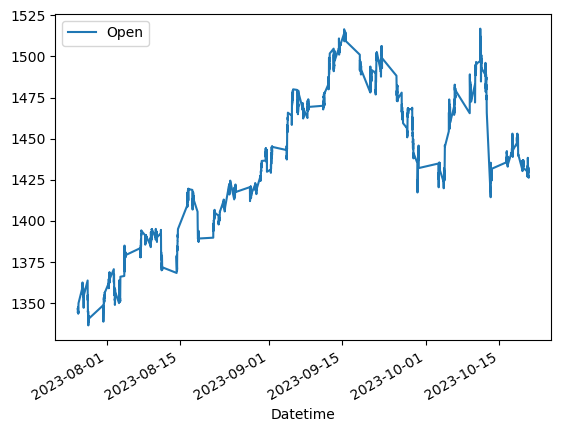

In [13]:
data[["Open"]].plot()

<AxesSubplot: ylabel='Frequency'>

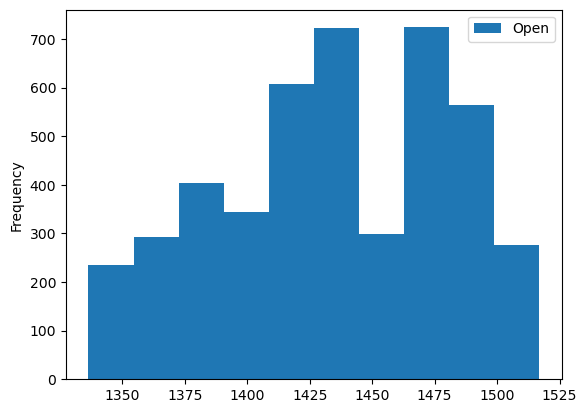

In [16]:
data[["Open"]].plot(kind="hist")

In [17]:
data[['MACD']].describe()

,MACD
count,4468.000000
mean,0.136757
std,1.944400
min,-13.863079
25%,-0.767835
50%,0.234306
75%,1.156207
max,8.441294


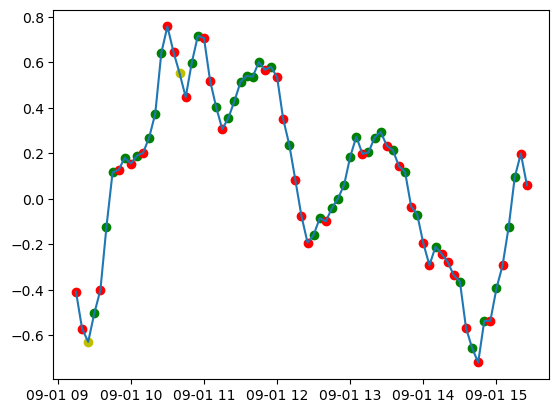

In [38]:
new_macd = data['MACD'] - data['MACDSIGNAL']
new_macd = new_macd.loc['2023-09-01']
buy = new_macd[trend==1]
sell = new_macd[trend==-1]
yello = new_macd[trend==0]
plt.scatter(buy.index,buy,c='g')
plt.scatter(sell.index,sell,c='r')
plt.scatter(yello.index,yello,c='y')
plt.plot(new_macd)


In [27]:
trend = np.sign(data['Close'] - data['Close'].shift(1)).loc['2023-09-01'].shift(-1)

In [40]:
new_macd = data['MACD'] - data['MACDSIGNAL']

In [41]:
new_macd.describe()

count    4468.000000
mean       -0.001499
std         0.560298
min        -4.401539
25%        -0.290583
50%        -0.020882
75%         0.269909
max         2.363616
dtype: float64

<AxesSubplot: ylabel='Frequency'>

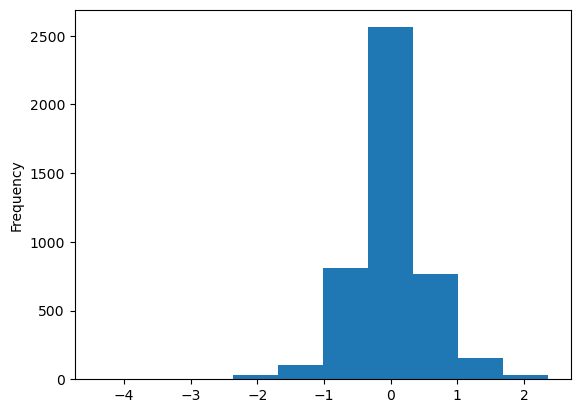

In [42]:
new_macd.plot(kind='hist')

In [43]:
# data['ATR']
(data['Close'].shift(-1) - data['Close'])

Datetime
2023-07-26 12:00:00+05:30    0.949951
2023-07-26 12:05:00+05:30    0.000000
2023-07-26 12:10:00+05:30    0.500000
2023-07-26 12:15:00+05:30    0.450073
2023-07-26 12:20:00+05:30    0.349976
                               ...   
2023-10-20 15:10:00+05:30   -0.300049
2023-10-20 15:15:00+05:30   -0.099976
2023-10-20 15:20:00+05:30    0.349976
2023-10-20 15:25:00+05:30    0.800049
2023-10-20 15:30:00+05:30         NaN
Name: Close, Length: 4468, dtype: float64

In [44]:
data['ATR']

Datetime
2023-07-26 12:00:00+05:30    1.543856
2023-07-26 12:05:00+05:30    1.533583
2023-07-26 12:10:00+05:30    1.488328
2023-07-26 12:15:00+05:30    1.482021
2023-07-26 12:20:00+05:30    1.461873
                               ...   
2023-10-20 15:10:00+05:30    1.872206
2023-10-20 15:15:00+05:30    1.895625
2023-10-20 15:20:00+05:30    1.895939
2023-10-20 15:25:00+05:30    1.903372
2023-10-20 15:30:00+05:30    1.824563
Name: ATR, Length: 4468, dtype: float64

In [45]:
data['ATR'].describe()

count    4468.000000
mean        2.107918
std         0.707344
min         0.697480
25%         1.629480
50%         1.992130
75%         2.473022
max         7.108454
Name: ATR, dtype: float64

In [46]:
data['rets'] = data.Close.shift(-1) - data.Close
corr_matrix = data[['rets','ATR']].corr()

In [47]:
corr_matrix

,rets,ATR
rets,1.000000,-0.040098
ATR,-0.040098,1.000000


In [51]:
corr_matrix = data[['High','Low','Open','Close','ATR']].corr()

In [52]:
corr_matrix

,High,Low,Open,Close,ATR
High,1.000000,0.999570,0.999701,0.999743,0.252402
Low,0.999570,1.000000,0.999714,0.999740,0.237025
Open,0.999701,0.999714,1.000000,0.999483,0.244561
Close,0.999743,0.999740,0.999483,1.000000,0.244540
ATR,0.252402,0.237025,0.244561,0.244540,1.000000


In [53]:
data['MACDHIST'].describe()

count    4468.000000
mean       -0.001499
std         0.560298
min        -4.401539
25%        -0.290583
50%        -0.020882
75%         0.269909
max         2.363616
Name: MACDHIST, dtype: float64

<AxesSubplot: xlabel='Datetime'>

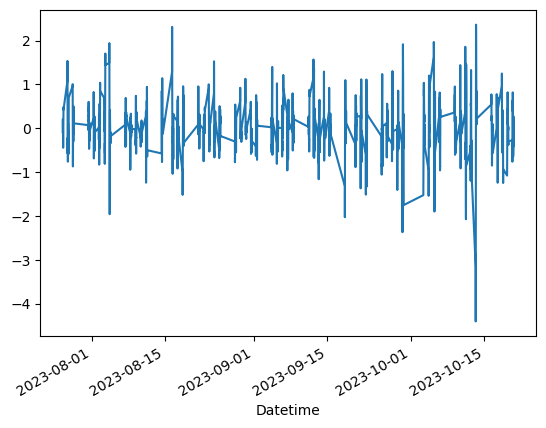

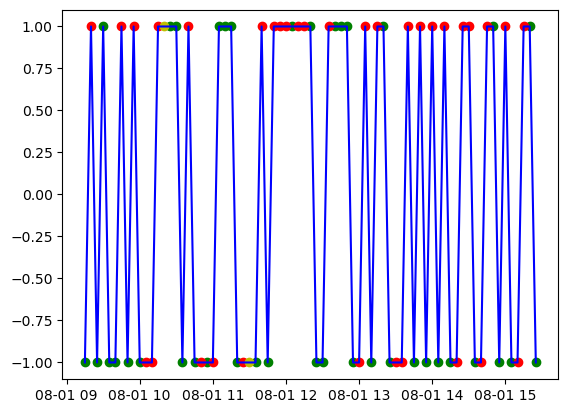

In [75]:
data['new_hist'] = (data.MACDHIST.shift(-1) - data.MACDHIST)
data['new_hist'] = np.sign(data.new_hist.shift(-1) - data.new_hist)
data['targets'] = np.sign(data.Close.shift(-1) - data.Close)
buy = data['new_hist'][data['targets']==1]
sell = data['new_hist'][data['targets']==-1]
hold = data['new_hist'][data['targets']==0]
plt.plot(data['new_hist'].loc['2023-08-01'],c='blue')
plt.scatter(buy.loc['2023-08-01'].index,buy.loc['2023-08-01'],c='g')
plt.scatter(sell.loc['2023-08-01'].index,sell.loc['2023-08-01'],c='r')
plt.scatter(hold.loc['2023-08-01'].index,hold.loc['2023-08-01'],c='y')

In [76]:
c_table = pd.crosstab(data['new_hist'],data['targets'])

In [77]:
c_table

targets,-1.0,0.0,1.0
new_hist,,,
-1.0,746,81,1389
1.0,1355,81,814


In [78]:
import scipy.stats
from scipy.stats import chi2_contingency

In [79]:
chi_2, p, dof, expected =  chi2_contingency(c_table)

In [80]:
chi_2

326.3654483498748

In [82]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MACD',
       'MACDSIGNAL', 'MACDHIST', 'ADX', 'MFI', 'OBV', 'RSI', 'SAR', 'SMA',
       'ATR', 'rets', 'new_macd', 'targets', 'new_hist'],
      dtype='object')

In [86]:
data.drop('Adj Close',axis=1,inplace=True)

In [87]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'MACDSIGNAL',
       'MACDHIST', 'ADX', 'MFI', 'OBV', 'RSI', 'SAR', 'SMA', 'ATR', 'targets',
       'new_hist'],
      dtype='object')

In [88]:
data['ADX'].describe()

count    4468.000000
mean       26.053906
std        10.895437
min         6.114661
25%        17.666135
50%        23.852445
75%        32.519589
max        62.249624
Name: ADX, dtype: float64

In [89]:
plus_dmi = talib.PLUS_DM(data.High,data.Low)
minus_dmi = talib.MINUS_DM(data.High,data.Low)

In [90]:
plus_dmi.describe()

count    4455.000000
mean        6.302736
std         3.327183
min         1.080369
25%         3.949762
50%         5.595832
75%         7.684724
max        27.683650
dtype: float64

In [91]:
minus_dmi.describe()

count    4455.000000
mean        6.145235
std         4.206904
min         0.371451
25%         3.590187
50%         5.199188
75%         7.676725
max        61.868552
dtype: float64

In [92]:
np.sign(plus_dmi - minus_dmi) * pd.cut

Datetime
2023-07-26 12:00:00+05:30         NaN
2023-07-26 12:05:00+05:30         NaN
2023-07-26 12:10:00+05:30         NaN
2023-07-26 12:15:00+05:30         NaN
2023-07-26 12:20:00+05:30         NaN
                               ...   
2023-10-20 15:10:00+05:30   -3.096568
2023-10-20 15:15:00+05:30   -3.625385
2023-10-20 15:20:00+05:30   -2.916478
2023-10-20 15:25:00+05:30   -2.808133
2023-10-20 15:30:00+05:30   -2.607552
Length: 4468, dtype: float64

In [100]:
data['ADX'].loc[data['ADX'].between(0,25,'both')] = 1
data['ADX'].loc[data['ADX'].between(25,50,'right')] = 2
data['ADX'].loc[data['ADX'].between(50,75,'right')] = 3
data['ADX'].loc[data['ADX'].between(75,100,'right')] = 4

/tmp/ipykernel_4309/2176643664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ADX'].loc[data['ADX'].between(0,25,'both')] = 1
/tmp/ipykernel_4309/2176643664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ADX'].loc[data['ADX'].between(25,50,'right')] = 2
/tmp/ipykernel_4309/2176643664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ADX'].loc[data['ADX'].between(50,75,'right')] = 3
/tmp/ipykernel_4309/2176

In [120]:
data['new_ADX'] = (np.sign(plus_dmi - minus_dmi) * data['ADX'])

In [111]:
c_table = pd.crosstab(data['ADX'],data['targets'])

In [112]:
chi_2, p, dof, expected =  chi2_contingency(c_table)

In [114]:
chi_2

2.7743436322703334

In [115]:
dof

4

In [130]:
from scipy.stats import f_oneway
buy = data['new_ADX'].loc[data['targets']==1].dropna()
sell = data['new_ADX'].loc[data['targets']==-1].dropna()
hold = data['new_ADX'].loc[data['targets']==0].dropna()
f_stat = f_oneway(buy,sell,hold)

In [131]:
f_stat

F_onewayResult(statistic=1.1163487853015068, pvalue=0.3275649610921221)

In [132]:
len(buy)+len(sell)+len(hold) - 1

4453

In [118]:
data['ADX'] = infy_data.data.ADX

In [135]:
print(scipy.stats.f.ppf(q=0.95,dfn=4453,dfd=2))

19.495501179357362


In [136]:
data['ATR'].describe()

count    4468.000000
mean        2.107918
std         0.707344
min         0.697480
25%         1.629480
50%         1.992130
75%         2.473022
max         7.108454
Name: ATR, dtype: float64

In [137]:
data['OBV'].describe()

count    4.468000e+03
mean     5.630813e+06
std      2.782056e+06
min     -5.466860e+05
25%      3.709320e+06
50%      5.442386e+06
75%      7.582793e+06
max      1.246845e+07
Name: OBV, dtype: float64

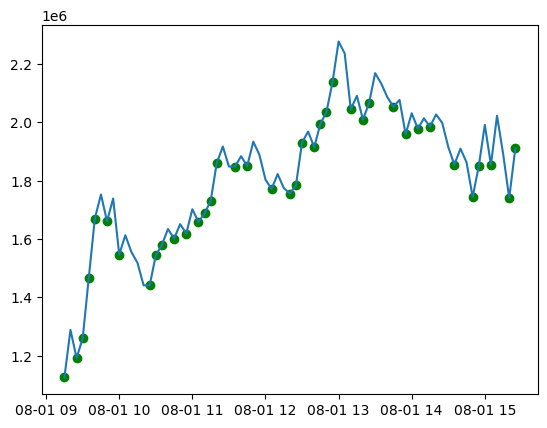

In [143]:
plt.plot(data['OBV'].loc['2023-08-01'])
plt.scatter(buy.loc['2023-08-01'].index,data['OBV'].loc[buy.loc['2023-08-01'].index],c='g')

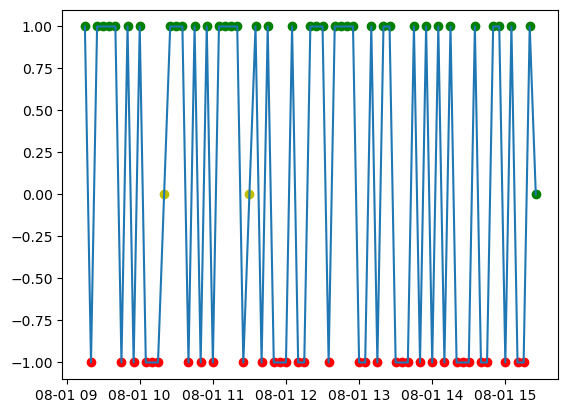

In [179]:
data['new_obv'] = np.sign(data['OBV'].shift(-1) - data['OBV'])
plt.plot(data['new_obv'].loc['2023-08-01'])
plt.scatter((data['new_obv'].loc[data['targets']==1]).loc['2023-08-01'].index,(data['new_obv'].loc[data['targets']==1]).loc['2023-08-01'],c='g')
plt.scatter((data['new_obv'].loc[data['targets']==-1]).loc['2023-08-01'].index,(data['new_obv'].loc[data['targets']==-1]).loc['2023-08-01'],c='r')
plt.scatter((data['new_obv'].loc[data['targets']==0]).loc['2023-08-01'].index,(data['new_obv'].loc[data['targets']==0]).loc['2023-08-01'],c='y')

In [148]:
c_table = pd.crosstab(data['new_obv'],data['targets'])
chi_2, p, dof, freq = chi2_contingency(c_table)

In [149]:
chi_2

7806.674654093318

In [155]:
# data['RSI']
buy = data['RSI'].loc[data['targets']==1]
sell = data['RSI'].loc[data['targets']==-1]
hold = data['RSI'].loc[data['targets']==0]
f_stat, p = f_oneway(buy,sell,hold)

In [169]:
np.sign(90)

1

In [165]:
c_table = pd.crosstab(data['new_sar'],data['targets'])

In [166]:
chi_2, p, dof, _ = chi2_contingency(c_table)

In [167]:
chi_2

0.20531449407492514

In [170]:
data['ATR'].describe()

count    4468.000000
mean        2.107918
std         0.707344
min         0.697480
25%         1.629480
50%         1.992130
75%         2.473022
max         7.108454
Name: ATR, dtype: float64

<AxesSubplot: ylabel='Frequency'>

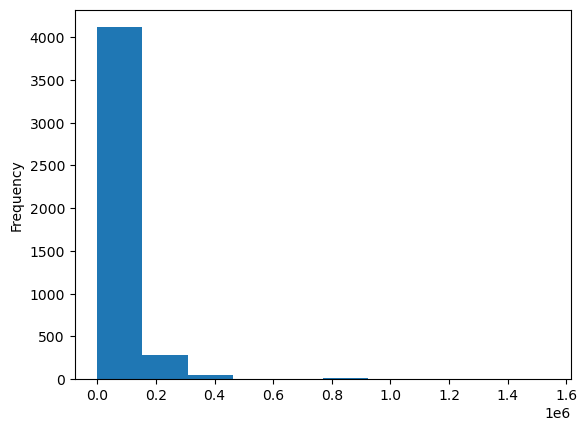

In [180]:
data.Volume.plot(kind='hist')

In [172]:
data['SMA'].describe()

count    4468.000000
mean     1434.073426
std        45.982375
min      1339.806665
25%      1397.931253
50%      1435.588334
75%      1473.220415
max      1513.521667
Name: SMA, dtype: float64

<AxesSubplot: xlabel='Datetime'>

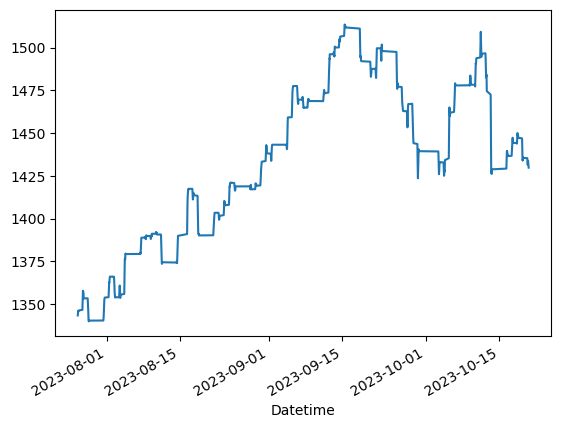

In [174]:
data.SMA.plot()

In [185]:
from sklearn.preprocessing import minmax_scale

In [186]:
minmax_scale([0,3,4,5,2,1])

array([0. , 0.6, 0.8, 1. , 0.4, 0.2])

In [72]:
df = pd.DataFrame({"a": [1,2,-3,4],
                   "b": [7,8,9,10],
                   "c": [11,12,34,-10]})


In [14]:
a_min =

1 10


In [15]:
df

,a,b,c
0,0.000000,0.666667,11
1,0.111111,0.777778,12
2,-0.444444,0.888889,34
3,0.333333,1.000000,15


In [73]:
for k in range(0,len(df),2):
    x = df.loc[k:k+1]
    a = x['a'].to_numpy()[0]
    c = x['c'].to_numpy()[-1]
    df.loc[k:k+1] = (df.loc[k:k+1] - a) / (c - a)


In [74]:
df

,a,b,c
0,0.000000,0.545455,0.909091
1,0.090909,0.636364,1.000000
2,-0.000000,-1.714286,-5.285714
3,-1.000000,-1.857143,1.000000


In [45]:
for k in range(0,len(df),2):
    print(k)

0
2


In [49]:
df.loc[0:1]

,a,b,c
0,0.000000,0.055556,0.916667
1,0.009259,0.064815,1.000000


In [84]:
df

,a,b,c
0,0.000000,0.545455,0.909091
1,0.090909,0.636364,1.000000
2,-0.000000,-1.714286,-5.285714
3,-1.000000,-1.857143,1.000000


In [94]:
ls = [0,0,1,1]
ls_2 = [0,1,0,1]
a = np.empty(shape = [2,2,3])
a[ls,ls_2] = df.to_numpy()

In [95]:
a

array([[[ 0.        ,  0.54545455,  0.90909091],
        [ 0.09090909,  0.63636364,  1.        ]],

       [[-0.        , -1.71428571, -5.28571429],
        [-1.        , -1.85714286,  1.        ]]])

In [96]:
infy_data.windowed_dataset.columns

Index(['level_0', 'level_1', 'Datetime', 'Open', 'High', 'Low', 'Close',
       'Volume', 'MACDHIST', 'ADX', 'MFI', 'OBV', 'RSI', 'SAR'],
      dtype='object')

In [114]:
level_0 = infy_data.windowed_dataset.level_0
level_1 = infy_data.windowed_dataset.level_1
data = infy_data.windowed_dataset.drop(['level_0','level_1'],axis=1)

In [102]:
np.unique(level_0)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68])

In [104]:
level_0.describe()

count    28490.000000
mean        33.991646
std         19.912156
min          0.000000
25%         17.000000
50%         34.000000
75%         51.000000
max         68.000000
Name: level_0, dtype: float64

In [115]:
for i,idx in enumerate(range(0,len(level_0),69)):
    print(i)
    print(68*i+level_0.loc[idx:idx+68])
    break

0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
      ...  
64      9.0
65      9.0
66      9.0
67      NaN
68    281.0
Name: level_0, Length: 69, dtype: float64


In [109]:
level_0.describe()

count    28072.000000
mean     42668.474174
std      24674.631403
min          0.000000
25%      21267.000000
50%      42669.500000
75%      64072.000000
max      85339.000000
Name: level_0, dtype: float64

In [110]:
len(infy_data.windowed_dataset)

28490

In [111]:
28490/7

4070.0

In [113]:
418*7

2926

In [116]:
infy_data.windowed_dataset

,level_0,level_1,Datetime,Open,High,Low,Close,Volume,MACDHIST,ADX,MFI,OBV,RSI,SAR
0,0.0,0,2023-07-31 09:15:00+05:30,2.445953,2.445953,-2.557122,-0.381865,0.000000,1.0,0.152629,0.566137,-1.0,0.480385,-1.0
1,0.0,1,2023-07-31 09:20:00+05:30,-0.147622,0.421315,-1.753942,-0.816932,0.094845,1.0,0.166952,0.543825,1.0,0.425763,-1.0
2,0.0,2,2023-07-31 09:25:00+05:30,-0.917304,-0.080667,-0.917304,-0.147622,0.118956,1.0,0.180252,0.607257,1.0,0.516790,-1.0
3,0.0,3,2023-07-31 09:30:00+05:30,-0.214537,1.241204,-0.331658,0.053203,0.142810,-1.0,0.202490,0.679259,1.0,0.540335,-1.0
4,0.0,4,2023-07-31 09:35:00+05:30,0.053203,0.538437,-0.465528,0.287445,0.044739,1.0,0.220709,0.691024,-1.0,0.566847,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28485,113763.0,2,2023-10-25 15:00:00+05:30,-0.507167,0.094586,-1.229271,-0.675705,0.126196,1.0,0.237309,0.407750,-1.0,0.416195,-1.0
28486,113763.0,3,2023-10-25 15:05:00+05:30,-0.675705,-0.675705,-1.686639,-0.916406,0.090570,-1.0,0.239914,0.325096,1.0,0.406716,-1.0
28487,113763.0,4,2023-10-25 15:10:00+05:30,-0.940441,0.359323,-0.940441,-0.001729,0.113152,-1.0,0.232341,0.429945,-1.0,0.457297,-1.0
28488,113763.0,5,2023-10-25 15:15:00+05:30,-0.025764,0.311194,-0.194302,-0.122080,0.127112,1.0,0.225309,0.476456,-1.0,0.451839,-1.0


In [119]:
level_1

0        0
1        1
2        2
3        3
4        4
        ..
28485    2
28486    3
28487    4
28488    5
28489    6
Name: level_1, Length: 28490, dtype: object

In [121]:
len(level_1)/7

4070.0

In [124]:
np.unique(level_0)

array([   0,    1,    2, ..., 4067, 4068, 4069])

In [19]:
df = pd.DataFrame({'a': [1,2,3,4,5,6]})
df.diff(2).shift(-2)

,a
0,2.0
1,2.0
2,2.0
3,2.0
4,NaN
5,NaN
